# Vision and map

In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

%matplotlib inline

## Create the map

In [7]:
#FORMAT PAYSAGE!!!!!!
max_val_x = 50 # Size of the map
max_val_y = 50

def create_empty_plot(max_val_x_=max_val_x, max_val_y_=max_val_y):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks = np.arange(0, max_val_x+1, 10)
    minor_ticks = np.arange(0, max_val_x+1, 10)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_val_y_])
    ax.set_xlim([-1,max_val_x_])
    ax.grid(True)
    
    return fig, ax

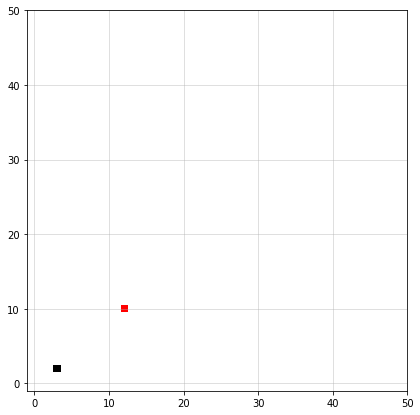

In [8]:
#REVOIR POUR IMPORTER LA MAP DEPUIS LA PHOTO
limit_empty = 1 
obstacle_here = 2
painting_here = 3

#Creating the grid
fig, ax = create_empty_plot()

# Creating the occupancy grid
np.random.seed(0) # To guarantee the same outcome on all computers
data = np.zeros((max_val_x, max_val_y)) # Create an empty grid of 168 x 118 values
cmap = colors.ListedColormap(['white', 'black', 'red']) # Select the colors with which to display obstacles and free cells
#Black is the obstacles
#Red is painting


#Convert pos of obstacles into
"""
obstacle_pos = getObstaclePos()
for i in range(0, len(obstacle_pos))
    data[obstacle_pos[0][0], obstacle_pos[0][1]]= obstacle_here
    
painting_pos = getPaintingPos()
for i in range(0, len(painting_pos))
    data[painting_pos[0][0], painting_pos[0][1]]= painting_here
    
"""
data[12,10] = painting_here
data[3,2] = obstacle_here

# Converting the random values into occupied and free cells
occupancy_grid = data.copy()
occupancy_grid[data==painting_here] = 2
occupancy_grid[data==obstacle_here] = 1
occupancy_grid[data==limit_empty] = 0

#GET THE POSITIONS OF PAINTINGS AND OBSTACLES FROM VISION

# Displaying the map
ax.imshow(occupancy_grid.transpose(), cmap=cmap)

In [9]:
def _get_movements_4n():
    """
    Get all possible 4-connectivity movements.
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0)]

def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
    return total_path

def A_Star(start, goal, h, coords, occupancy_grid, movement_type="4N"):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid: the grid map
    :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """

    for point in [start, goal]:
        assert start[0]>=0 and start[1]>=0 and goal[0]>=0 and goal[1]>=0 and start[0]<max_val_x and start[1]<max_val_y and goal[0]<max_val_x and goal[1]<max_val_y, "start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get possible movements
    if movement_type == '4N':
        movements = _get_movements_4n()
    
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]

    # while there are still elements to investigate
    while openSet != []:
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
            return reconstruct_path(cameFrom, current), closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0], neighbor[1]]==obstacle_here) or (neighbor in closedSet): 
                continue
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
                
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet


Enter the order you want to to see the paintings in :0


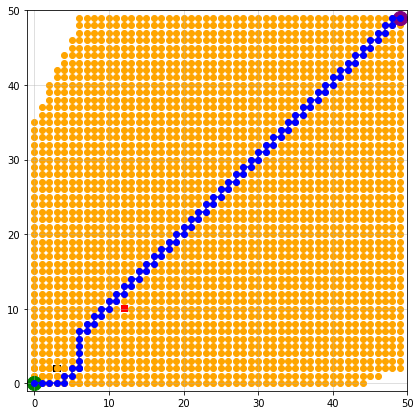

In [11]:
##### HERE THE POS OF PAINTINGS ARE GIVEN
import numpy as np

# Define the start and end goal constant with entrance and exit of museum
entrance = (0,0)
exit = (49,49) #TO MODIFY IF NEEDED
pos_paintings = (6, 2, 12, 0) #HERE POSITIONS GIVEN BUT AFTER WILL BE EXTRACTED


# List of all coordinates in the grid
x,y = np.mgrid[0:max_val_x:1, 0:max_val_y:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
coords = list([(int(x[0]), int(x[1])) for x in pos])
path = []
visitedNodes = []

p = input('Enter the order you want to to see the paintings in :')
visiting_order = []
i = 0
x_t = []
y_t = []
pos_int = 0
while i<len(p) :
    if p[i].isdigit():
        visiting_order.append(int(p[i]))
        nb = int(p[i]) #number from 0 to nb paint-1
        x_t.append(float(pos_paintings[2*nb]))
        y_t.append(float(pos_paintings[2*nb+1]))
    i = i + 1
    
coords_goal = list([x_v, y_v] for (x_v,y_v) in zip(x_t,y_t))

previous_pos = entrance #Start position
goal_pos = coords_goal[0]

for goal_pos in coords_goal:
    # Define the heuristic, here = distance to goal ignoring obstacles
    h = np.linalg.norm(pos - goal_pos, axis=-1)
    h = dict(zip(coords, h))
    goal_pos[0] = int(goal_pos[0])
    goal_pos[1] = int(goal_pos[1])

    # Run the A* algorithm #PUT ALL TOGETHER
    new_path, new_visitedNodes = A_Star(tuple(previous_pos), tuple(goal_pos), h, coords, occupancy_grid, movement_type="4N")
    if len(path) == 0:
        path = np.array(new_path).reshape(-1, 2).transpose()
    else:
        path = np.concatenate((path, np.array(new_path).reshape(-1, 2).transpose()), axis=1)
    
    if len(visitedNodes) == 0:
        visitedNodes = np.array(new_visitedNodes).reshape(-1, 2).transpose()
    else:
        visitedNodes = np.concatenate((visitedNodes, np.array(new_visitedNodes).reshape(-1, 2).transpose()), axis=1)
    
    previous_pos = goal_pos

#####GO TO EXIT
goal_pos = exit
# Define the heuristic, here = distance to goal ignoring obstacles
h = np.linalg.norm(pos - goal_pos, axis=-1)
h = dict(zip(coords, h))

# Run the A* algorithm
new_path, new_visitedNodes = A_Star(tuple(previous_pos), goal_pos, h, coords, occupancy_grid, movement_type="4N") 
if len(path) == 0:
        path = np.array(new_path).reshape(-1, 2).transpose()
else:
    path = np.concatenate((path, np.array(new_path).reshape(-1, 2).transpose()), axis=1)

if len(visitedNodes) == 0:
    visitedNodes = np.array(new_visitedNodes).reshape(-1, 2).transpose()
else:
    visitedNodes = np.concatenate((visitedNodes, np.array(new_visitedNodes).reshape(-1, 2).transpose()), axis=1)

##### Displaying the map
fig_astar, ax_astar = create_empty_plot()
ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)

# Plot the best path found and the list of visited nodes
ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange')
ax_astar.plot(path[0], path[1], marker="o", color = 'blue')
ax_astar.scatter(entrance[0], entrance[1], marker="o", color = 'green', s=200)
ax_astar.scatter(exit[0], exit[1], marker="o", color = 'purple', s=200)